<a href="https://colab.research.google.com/github/ashikshafi08/Learning-Fastai/blob/main/Collaborative_Filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fastai -q --upgrade

     |████████████████████████████████| 189 kB 8.2 MB/s 
     |████████████████████████████████| 56 kB 2.7 MB/s 


In [2]:
# Importing the needed stuffs 
import fastai 
from fastai.collab import * 
from fastai.tabular.all import * 
print(fastai.__version__)

2.5.3


# Collaborative Filtering Deep Dive 

A very common problem to solve in deeplearning is when you have a number of users and a number of products, and you want to recommend which products are most likely to be useful for which uses.

Also there are many variations of this for example, 
- Recommending movies (such as Netflix) 
- Figuring out what to highlight for a user on a home page. 
- Deciding what stories to show in a social media feed. 

The above examples can be solved by using a method called collaborative filtering, which works like this: **look at what products the current user has used or liked, find other users that have used or liked the similar products, and then recommend other products that those users have used or liked**. 

For example, on Netflix you may have watched lots of movies that are science fiction or full of action, and that were made in the 1970s. Netflix may not know these particular properties of the file we watched., but it will be able to see that other people that have watched the same movies that you watched also tended to watch other movies that are science fiction. 

In a nutshell we dont wanna know anything about the movie, except who like to watch them. And in collaborative filtering we more commonly refer to **items**, rather than *products*. Items could be links that the people click on, diagnoses that are selected for the patients and so forth. 

The key foundational idea is that of **latent factors** in the collaborative filtering. 

In the Netflix example, we started with a assumption that you like old, action packed sci-fi movies. But we never actually told Netflix that we like these kind of movies. Still, there must be some underlying concept of sci-fi, action, and movie age, and these concepts must be relevant for at least some people's movie watching decisions.

In [3]:
# Getting the data 
path = untar_data(URLs.ML_100k)

# Looking into the data 
path.ls()

(#23) [Path('/root/.fastai/data/ml-100k/u.user'),Path('/root/.fastai/data/ml-100k/u.occupation'),Path('/root/.fastai/data/ml-100k/u.genre'),Path('/root/.fastai/data/ml-100k/README'),Path('/root/.fastai/data/ml-100k/u3.base'),Path('/root/.fastai/data/ml-100k/u4.test'),Path('/root/.fastai/data/ml-100k/u4.base'),Path('/root/.fastai/data/ml-100k/u2.base'),Path('/root/.fastai/data/ml-100k/ub.test'),Path('/root/.fastai/data/ml-100k/u3.test')...]

In [4]:
# Loading in the data 
ratings = pd.read_csv(path/'u.data' , delimiter='\t' , header = None , 
                      names = ['user' , 'movie', 'rating', 'timestamp'])

ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


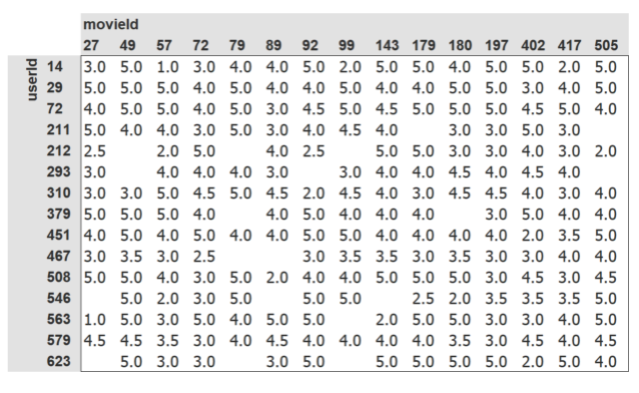

For each user, we would like to figure out which of those movies they might be most likely to enjoy. 

If we knnew for each user to what degree they liked each important category that a movie might fall into, such as genre, age , preferred directors and actors and so forth. 

We knew the same information about each movie, then a simple way to fill in the above table would be multiplying this information together for each movie and use a combination. 

For instance, assumig these factors ranging between -1 and +1, with positive numbers indicating stronger matches and negative numbers indicating weaker matches, and the categories can be `[sci-fic , action , old movies]`, then we would represent the movie `The Last Skywalker` as:

In [5]:
last_skywalker = np.array([0.98 , 0.9 , -0.9])

Here for instance we are scoring the movie, very sci-fi as 0.98, very action as 0.9 and very not old as -0.9. And we would represent a user who likes modern sci-fi movie as: 


In [6]:
# A random user who likes sci-fi movies 
user_1 = np.array([0.9 , 0.8 , -0.6])

In [7]:
# Calculating the match between two 
(user_1 * last_skywalker).sum()

2.1420000000000003

When we multiply two vectors together and add up the results, this is known as **dot product**. 

In [8]:
# Representing the movie casablanca 
casablanca = np.array([-0.99 , -0.3 , 0.8])

# Finding the combination 
(user_1 * casablanca).sum()

-1.611

## Learning the Latent Factors 

There will be a little difference between specifiying the structure of a model, as we did in the previous lecture and the current one. 

**Step 1 of this approach** 
- Randomly intialize some parameters. These parameters will be a set of latent factors for each user and movie.
- We will have to decide how many to use, but for now we will use just 5 for now. 
- Nowe each user and movie will have a set of these factors in the below cross tab and we can show these randomly intialized values right next to the users and movies in our cross tab and we can fill in the dot products for each of these combinations in the middle. 

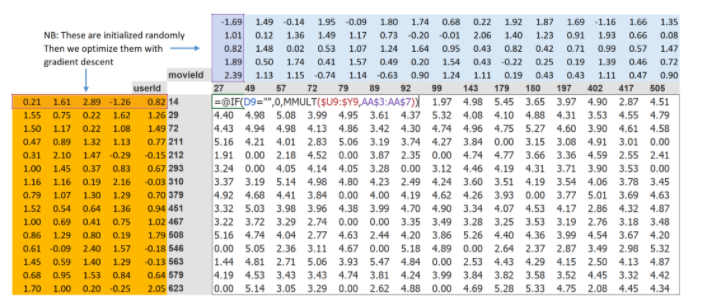

**Step 2 of this approach** 
- That is to calculate the predictions. And we can do this by simply taking the dot products of each movie with each user. 
- For instane, the first latent user factor represents how much the user likes action movies and the first latent movie factor represents if the movie has a lot of action or not. The **product of those will be particularly high** if either the user likes action movies and the movie doesnt have any action in it. 
- On the other hand if we hav mismatch (a user loves action movies but the movie isnt an action film, or the user doesnt like action movies and it is one), the product will be very low. 

**Step 3 of the is approach** 
- Calculate our loss, we can use any loss function. 
- For this we will be using MSE (mean squared error). 

Thats all we need: 
- Randomly initialized parameters (latent features) 
- Calculate the predictions (the results of the dot product). 
- Calculate the loss between the predictions and the actual rating. 

Now our goal is to optimize the parameters (latent factors) using SGD, such as to minimize the loss. At each step, the **SGD optimizer will calculate the match between each moovie and each user using the dot product**.

It will then calculate the derivative of this value and will step the weights by multiplying this by the learning rate. After doing this lots of times, the loss will get better and better and the recommendations will also get better and better. 

### Creating the DataLoaders

Lets get the movie title's than their ID's for a better visualization. The table `u.item` contains the correspondance of ID's to titles

In [9]:
# Loading in the movie titles 
movies = pd.read_csv(path/'u.item', delimiter = '|' , encoding= 'latin-1', 
                     usecols = (0,1), names = ('movie', 'title'), header = None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [10]:
# Mergiing the rating df with the movies one 
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


Using the `CollabDataLoaders` to build our DataLoaders. By default, it takes the first columns for the user, and the second column for the item (here our movies) and the third column for the ratings. 

We need to change the value of `item_name` in our case to use the title instead of the ID's 

In [11]:
dls = CollabDataLoaders.from_df(ratings , item_name = 'title' , bs = 64)
dls.show_batch()

,user,title,rating
0,158,Emma (1996),5
1,655,"White Balloon, The (1995)",3
2,474,When Harry Met Sally... (1989),4
3,847,"Fish Called Wanda, A (1988)",4
4,65,Liar Liar (1997),4
5,416,G.I. Jane (1997),5
6,535,It's a Wonderful Life (1946),5
7,376,Seven (Se7en) (1995),4
8,445,"Jackal, The (1997)",1
9,138,Mr. Holland's Opus (1995),4


We cant represent collaborative filtering in Pytorch with the cross tab representation directory, but instead we can **represent the movie and latent factor tables are simple matrices**

In [12]:
# Should return 3 elements (id , title, rating)
dls.classes

{'title': ['#na#', "'Til There Was You (1997)", '1-900 (1994)', '101 Dalmatians (1996)', '12 Angry Men (1957)', '187 (1997)', '2 Days in the Valley (1996)', '20,000 Leagues Under the Sea (1954)', '2001: A Space Odyssey (1968)', '3 Ninjas: High Noon At Mega Mountain (1998)', '39 Steps, The (1935)', '8 1/2 (1963)', '8 Heads in a Duffel Bag (1997)', '8 Seconds (1994)', 'A Chef in Love (1996)', 'Above the Rim (1994)', 'Absolute Power (1997)', 'Abyss, The (1989)', 'Ace Ventura: Pet Detective (1994)', 'Ace Ventura: When Nature Calls (1995)', 'Across the Sea of Time (1995)', 'Addams Family Values (1993)', 'Addicted to Love (1997)', 'Addiction, The (1995)', 'Adventures of Pinocchio, The (1996)', 'Adventures of Priscilla, Queen of the Desert, The (1994)', 'Adventures of Robin Hood, The (1938)', 'Affair to Remember, An (1957)', 'African Queen, The (1951)', 'Afterglow (1997)', 'Age of Innocence, The (1993)', 'Aiqing wansui (1994)', 'Air Bud (1997)', 'Air Force One (1997)', 'Air Up There, The (199

In [13]:
# Initializing the parameters for our user and movie matrices 
n_users = len(dls.classes['user'])
n_movies = len(dls.classes['title'])

# The latent factors is 5 for now 
n_factors = 5

# Creating the weight matrices by randomly initializing the parameters 
user_factors = torch.randn(n_users , n_factors)
movie_factors = torch.randn(n_movies , n_factors)

print(n_users , n_movies)

944 1665


In [14]:
# How does the user_factors look like? 
user_factors[:5] # intializing random parameters for the 5 latent factors 

tensor([[-1.2676,  0.0359,  0.8210, -0.5980,  0.1644],
        [-0.4687, -2.2842, -0.0365, -0.0345, -1.7009],
        [ 0.9563,  0.0340, -0.3813,  0.6304, -0.1943],
        [ 0.3327, -1.7056, -0.6961,  0.2073, -0.1848],
        [-1.3947, -0.4245,  0.4316, -2.6918,  0.4027]])

In [15]:
one_hot(3 , 944).float()

tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

We got the matrix, but how do we optimize the latent factors for each movie and user? We have to locate each latent factors of the at particular movie and user in order to optimize it. But *look up in an index* is not an operation our deeplearning model knows how to do. 

For this reason we use **one-hot encoding** so that we can represent *look up in an index* as a matrix product. The trick is to replace our indices with one-hot encoded vectors . 

In [16]:
# Trying to locate the index 3 
one_hot_3 = one_hot(3 , n_users).float()

In [17]:
# Performing loo up an index 
print(f'Locating by using the one hot encoding: {user_factors.t() @ one_hot_3}\n') 
print(user_factors[3])

Locating by using the one hot encoding: tensor([ 0.3327, -1.7056, -0.6961,  0.2073, -0.1848])

tensor([ 0.3327, -1.7056, -0.6961,  0.2073, -0.1848])


But we cant do this manually for every indices and the latent feture, because it would use a lot more memory and time. 

Also we know there is no underlying reason to store the one-hot encoded vector and search using it. What if we can do the *look up* into a array directly with an integer itself `user_factor[3]`?

Therefore most deeplearning libraries including Pytorch, include a special layer that does just this: 
- **it indexes into a vector using an integer, but has its derivative calculated in such a way that it is identical to what it owuld have been if it had done a matrix multiplication with a one-hot encoded vector.**

This is called Embedding. 

> **Embedding**: Multiplying by a one-hot encoded matrix, using the computational shortcut that it can implemented by simpply indexing directly. This is quite a fancy word for a very simple concept. The thing that you multiply the one-hot encoded matriix by (or , using the computational shortcut, index into directly) is called the embedding matrix. 


In a computer vision we had the RGB values which is enough to get our model to work afterward. 

But for this collaborative filtering, we dont have the same easy way to characterize a user or a movie. There are probably relations with genres. 
- **If a given user likes romance, they are likely to give higher scores to romance movies**

Other factors might be whether the movie is more action oriented versus heavy on dialogue, or the presence of specific actor that a user might like. 

How do we determine numbers to characterize those? The answer is, we don't rather we will let our model learn them. By analyzing the existing relations bwteen users and movies, our model can figure out itself the features that seem important or not. 

This is what embeddings are,
- we will attribute to each of our users each of our movies a random vector of a certain length (here,  n_factors = 5)
- we will make those learnable parameters (those vector will be learning patterns). 
- so that means at each step, when we compute the loss by comparing our predictions to our targets, we will compute the gradients of the loss w.r.t those embedding vectors and update them with the rule oof SGD (or another optimizer). 

At the beginning, those numbers don't mean anything but by the end of training, they will. 

By learning on existing data about the relations between users and movies, without having any other information we will see that they still get some important features, and can later isolate blockbusters from other movies...

**Important tidbits** 
- We use `nn.Embedding` to represent our matrix, but we can use it as an lookup-index and also these embeddings are trainable. This means as the epochs goes, the embeddings will learn patterns around the data for better representation. 
- For the Colab Filtering, every element has a certain latent features that defines the attributes of the features. 


In [18]:
# Building the DotProduct from scratch 
class DotProduct(nn.Module):

  def __init__(self , n_users,  n_movies , n_factors):
    super(DotProduct , self).__init__()

    self.user_factors = nn.Embedding(n_users, n_factors)
    self.movie_factors = nn.Embedding(n_movies , n_factors)

  # The forward method (which defines the model)
  def forward(self , x):
    users = self.user_factors(x[: , 0]) # indexing the user ids 
    movies = self.movie_factors(x[: , 1]) # indexing the movie ids 
    return (users*movies).sum(dim = 1)

In [19]:
model = DotProduct(n_users , n_movies , n_factors= 50)


# Taking a batch of the dataloaders 
x , y = dls.one_batch()

In [20]:
# Creating a learner out of the model we've created 
learn = Learner(dls , model , loss_func = MSELossFlat())

In [21]:
# Training for 5 epochs 
learn.fit_one_cycle(5 , 5e-3)

epoch,train_loss,valid_loss,time
0,48.127960,46.421780,00:11
1,22.645096,24.461365,00:11
2,7.568885,11.871532,00:11
3,3.462877,8.443743,00:11
4,2.627463,8.038603,00:11


The models performance isn't any good, lets force those predictions to be between 0 and 5 by using a `sigmoid_range`

In [22]:
class DotProduct(nn.Module):

  def __init__(self , n_users, n_movies, n_factors , y_range = (0, 5.5)):
    super(DotProduct , self).__init__()

    self.user_factors = Embedding(n_users, n_factors)
    self.movie_factors = Embedding(n_movies, n_factors)
    self.y_range = y_range 

  def forward(self , x):
    users = self.user_factors(x[: ,0])
    movies = self.movie_factors(x[: ,1])
    return sigmoid_range((users*movies).sum(dim = 1) , *self.y_range)


In [23]:
# Training the model again with a sigmoid range
model = DotProduct(n_users, n_movies, n_factors= 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.018992,1.001143,00:11
1,0.881196,0.911554,00:11
2,0.658220,0.874441,00:11
3,0.490921,0.885562,00:11
4,0.378854,0.891036,00:11


We can do still better, there is one missing piece. There are instances, where a user might like the movie but yet they provide low ratings (or) the user might not like the movie yet they provided good ratings. 

How to balance this bias in our above model? Well we add something to our weights called a **bias**. This bias will handle this missing piece very nicely. 

In [24]:
Embedding , nn.Embedding

(fastai.layers.Embedding, torch.nn.modules.sparse.Embedding)

In [25]:
# Using the Fastai embedding layers 
class DotProductBias(Module):

  def __init__(self, n_users , n_movies , n_factors , y_range = (0 , 5.5)):
    super(DotProductBias , self).__init__()

    self.user_factors = Embedding(n_users , n_factors)
    self.user_bias = Embedding(n_users , 1) # just a number 

    self.movie_factors = Embedding(n_movies , n_factors)
    self.movie_bias = Embedding(n_movies , 1)

    self.y_range = y_range

  def forward(self,  x):
    users = self.user_factors(x[:,0])
    movies = self.movie_factors(x[:,1])
    res = (users * movies).sum(dim=1, keepdim=True)
    res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
    return sigmoid_range(res, *self.y_range)

In [26]:
# Training the model again 
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.981041,0.943363,00:12
1,0.810617,0.865676,00:12
2,0.617619,0.867047,00:12
3,0.400275,0.891662,00:12
4,0.297953,0.899059,00:12


We can observe that our validation loss has stopped improving after a certain epoch this clearly shows our model is overfitting. To prevent this we use a regularizaion technique called **weight decay**.

Regularization is a set of techniques that will help us to use a model with lots of parameters, train them for a long period of time but penalize them effectively preventing them from overfitting. 

## Weight Decay 
- Weight decay or L2 regularization is adding sum of all weights squared to our loss function 
- By doing this, when we compute the gradients it will add a contribution to them that will encourage the weights to be as small as possible. 

We can reduce the latent features in order to avoid overfitting, but instead we can try and force the  parameters to be smaller unless they required to be big. 

`loss_func + sqrt(weights) * some_factor`

**But how this will work?**
So now if we want to reduce the loss, we can just decrease the weights. Also by using a weight decay we are not letting our model to learn high parameters and fit it into all the data points. 

Weight decay limit our weights from growing too much also it will yield a state where it generalizes better.  

In [27]:
# Adding weight decay to our model 
model = DotProductBias(n_users , n_movies , 50)
learn = Learner(dls , model , loss_func = MSELossFlat())
learn.fit_one_cycle(5 , 5e-3 , wd = 0.1)

epoch,train_loss,valid_loss,time
0,0.928952,0.953530,00:12
1,0.846608,0.881653,00:12
2,0.712243,0.836614,00:12
3,0.601315,0.829074,00:12
4,0.504357,0.829331,00:12


Awesome now our val_loss is decreasing and as we train our model it will further decrease. 

Lets see how to build our own Embedding Module 

## Creating our own Embedding Module 
While building our `DotProductBias` we've been using the nn.Embedding and Fastai's Embedding module to create our embedding vectors. But what if we create our embedding module instead? 

Well that would be cool, also we get to learn whats the underlying working principle behind it. 

Lets create a simple class 

In [34]:
# Using the Fastai Module instead of the Pytorch's Moodule 
class T(Module):
  def __init__(self):
    self.a = torch.ones(3)


# Instantiating the class 
l = T()

# Accessing the parameters of the class we've just created 
l.parameters()


<generator object Module.parameters at 0x7f570ddd8950>

To treat a tensor as a parameters of the model we have to wrap them inside a `nn.Parameter` class. 

So now this class gives us an functionality of the `requires_grad_()` functionality to derive the gradients for our tensors. 

Looking at the example below we can infer that how the `nn.Parameter` is used and also adds the functionality of the gradients. 


https://stackoverflow.com/questions/50935345/understanding-torch-nn-parameter



In [35]:
wit = torch.ones(3)
wit_nn = torch.nn.Parameter(torch.ones(3))

wit , wit_nn

(tensor([1., 1., 1.]), Parameter containing:
 tensor([1., 1., 1.], requires_grad=True))

In [37]:
# Wrapping the tensor inside the the nn.Parameter 
class T(Module):
  def __init__(self):
    self.a = nn.Parameter(torch.ones(3))

print(L(T().parameters()))

[Parameter containing:
tensor([1., 1., 1.], requires_grad=True)]


Likewise we do in the TensorFlow using the `trainable = True` parameter, instead here using the `nn.Parameter` means our parameters our traianble. 


Instead of the parameter lets add a linear layer and see how it goes. 

In [48]:
class TLinear(Module):
  def __init__(self):
    self.a = nn.Linear(1 , 3 , bias = True)

t = TLinear()

# Looking inside whats the parameters are 
print(t.parameters())

<generator object Module.parameters at 0x7f570a39bb50>


In [49]:
# Checking the weight of the tensor 
t.a.weight 

Parameter containing:
tensor([[0.4430],
        [0.1113],
        [0.8672]], requires_grad=True)

In [50]:
# Checking the type of weight generaated inside our class
type(t.a.bias) , type(t.a.weight)

(torch.nn.parameter.Parameter, torch.nn.parameter.Parameter)

Likewise we can create a tensoor without random initialization. 


In [54]:
def create_params(size):
  return nn.Parameter(torch.zeros(*size).normal_(0 , 0.01))

Building the `DotProductBias` without an Embedding Layer!! 

In [57]:
class DotProductBias(Module):

  def __init__(self , n_users , n_movies , n_factors , y_range = (0 , 5.5)):
    self.user_factors = create_params([n_users , n_factors])
    self.user_bias = create_params([n_users])

    self.movie_factors = create_params([n_movies , n_factors])
    self.movie_bias = create_params([n_movies])

    self.y_range = y_range

  def forward(self , x):
    users = self.user_factors[x[: , 0]]
    movies = self.movie_factors[x[: , 1]]

    res = (users * movies).sum(dim = 1)
    res += self.user_bias[x[: , 0]] + self.movie_bias[x[: , 1]]
    return sigmoid_range(res , *self.y_range)

In [58]:
# Training the model again with our newl created Embedding layer 
model = DotProductBias(n_users , n_movies , 50)

# Creating a learner 
learn = Learner(dls , model , loss_func = MSELossFlat())
learn.fit_one_cycle(5 , 5e-3 , wd = 0.1)

epoch,train_loss,valid_loss,time
0,0.940091,0.943178,00:14
1,0.832205,0.880035,00:14
2,0.711115,0.832380,00:14
3,0.583571,0.821893,00:14
4,0.475603,0.822826,00:14
